<a href="https://colab.research.google.com/github/sofiaarosa/HuggingFaceNLPCourse/blob/main/02HFTransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biblioteca Transformers Hugging Face
**Curso PLN Hugging Face**

O pytorch foi o escolhido para a implementação e anotações dos módulos do curso do Hugging Face.


In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

## Função `pipeline()`



In [4]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [5]:
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

[{'label': 'POSITIVE', 'score': 0.9598048329353333},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

A função `pipeline()` agrupa o pré processamento, passagem das entradas através do modelo e o pós processamento.  

Quando a função é utilizada em seu *core*, nada do que será trabalhado nesse notebook precisará ser feito, pois a função possibilita que os Transformers sejam utilizados em alto nível. Porém, é interessante entender o processo por trás para personalizar a experiência da utilização da biblioteca.


### Pré Processamento
Mapear a entrada para alguma forma que o modelo possa entender. Isso inclui a tokenização, criação de embeddings para cada token da frase e a adição de entradas adicionais

Todo o pré processamento precisa seguir a forma como o modelo utilizado foi pré treinado - precisamos utilizar o mesmo tokenizer. Após obtermos o tokenizer, o utilizaremos para adicionar um dicionário ao modelo e, por fim, transformar esse dicionário em Tensores.

In [1]:
# obtenção do tokenizer do modelo default

from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [13]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
    "This course is amazing!"
]

# obtenção dos tensores que representam os identificadores de cada token

inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  2023,  2607,  2003,  6429,   999,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


#### Aprofundando nos tokenizers

* A função `AutoTokenizer` carrega o tokenizer apropriado, dado um checkpoint (parâmetros de um modelo transformer).

* É possível carregar o tokenizer específico de um determinado modelo, por exemplo `BertTokenizer` e específico de um checkpoint, com o método `from_pretreined()`.

* Tokenization = transformar uma frase numa lista de strings (tokens) do vocabulário do tokenizer

* Em seguida, é preciso converter tokens em ids numéricos que os representem no vocabulário

* Podemos realizar o *Decoding*, que é transformar um conjunto de índices de vocabulário em uma frase

In [7]:
from transformers import BertTokenizer
bTokenizer = BertTokenizer.from_pretrained(checkpoint)

sequence = "This course is amazing!"
tokens = bTokenizer.tokenize(sequence)
ids = bTokenizer.convert_tokens_to_ids(tokens)

print(tokens)
print(ids)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


['this', 'course', 'is', 'amazing', '!']
[2023, 2607, 2003, 6429, 999]


#### Tensores
Os modelos esperam sempre uma lista de frases. Por isso é importante que os tensores enviados sejam uma matriz.



```
errado = tensor([  101,  1045,  1005,  2310,  2042, 3403,  2005,  1037, 17662, 12172, 2607,  2026,  2878,  2166,  1012,   102])

certo = tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172, 2607,  2026,  2878,  2166,  1012,   102]])

```



Os tensores são matrizes e, para serem passados para os modelos, devem ser ***retangulares***, ou seja, as frases de uma lista devem ter o mesmo tamanho. Em casos de frases com quantidade de tokens distintos, é adicionado uma palavra especial (chamada de padding token) nas frases menores. No exemplo das três frases, é possível observar que as duas últimas frases, mais curtas, são acrescidas de tokens `0`, para deixá-las do mesmo tamanho da primeira frase.

O `tokenizer` realiza todas essas operações de ajuste para o modelo automaticamente.

### Passando a entrada pelo modelo

Primeiramente, é importante obter o modelo pré treinado.

O módulo base do Transformer utilizado pelos modelos produz os chamados hidden states, que são vetores de alta dimensionalidade que representam a compreensão contextual da entrada pelo Transformer.

Os hidden states são passados para outra parte do modelo, a cabeça (head).

No final, o modelo fica composto pela rede neural Transformer e a(s) cabeça(s) do modelo.

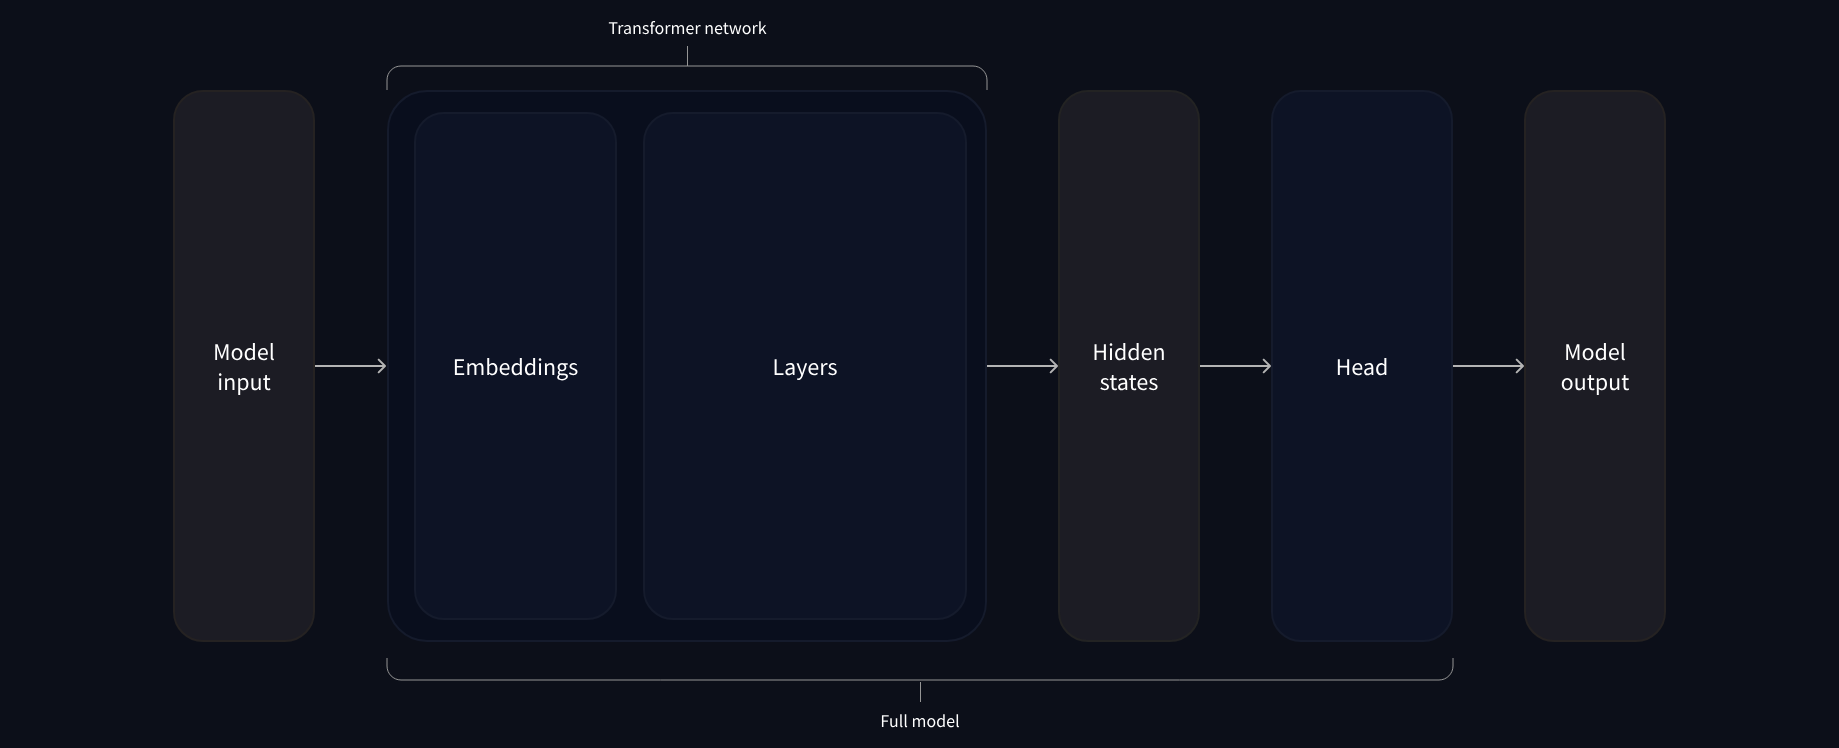

O output do módulo básico do transformer é de ***alta dimensionalidade***. Esse output é recebido pela head do modelo e é transformada num vetor de baixa dimensionalidade - um por cada label.

Primeiramente, iremos baixar o modelo pré-treinado da mesma forma como foi feito com o tokenizer e alimentar os inputs pré processados para ele.

Quando utilizamos a classe `AutoModel`, obtemos o modelo apenas com o módulo base Transformer.

Quando utilizamos outras classes, como a `AutoModelForSequenceClassification`, obtemos o modelo com a head específica para a tarefa desejada - neste caso, Sequence Classification é a tarefa desejada para o pipeline "sentiment-analysys".

In [14]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([3, 16, 768])


In [16]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits.shape)
print(outputs.logits)

torch.Size([3, 2])
tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464],
        [-4.3630,  4.6859]], grad_fn=<AddmmBackward0>)


É importante destacar: os modelos transformer podem limitar o comprimento das sequências processadas.

### Pós-processamento da saída

A saída do modelo transformer (composto pelo módulo básico do transformer e a head) é chamada de `logits`, que é a pontuação bruta da classificação. Para essa pontuação se tornar interpretável e também transformar essa pontuação em uma ***probabilidade***, ou seja, um número entre 0 ou 1 para cada uma das labels, os resultados passam por uma camada SoftMax.

In [17]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04],
        [1.1750e-04, 9.9988e-01]], grad_fn=<SoftmaxBackward0>)
